In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
%matplotlib inline

# Preprocessing

In [2]:
df=pd.read_csv("Real estate.csv")

In [3]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [4]:
df=df.drop("No",axis=1)

In [5]:
df.columns=["transaction date","house age","distance from MRT","number of conv stores","lat","long","prices per unit"]

In [6]:
df["transaction date"]=[int(str(x)[:4]) for x in df["transaction date"]]

In [7]:
df=df[df["distance from MRT"]<5000]

In [8]:
df=df[df["prices per unit"]<100]

In [9]:
x=df.drop("prices per unit",axis=1)
y=df["prices per unit"]

In [10]:
mms=MinMaxScaler()
pca=PCA(.95)

In [11]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=.25)

In [12]:
xtrain=pd.DataFrame(mms.fit_transform(xtrain),columns=x.columns)
xtest=pd.DataFrame(mms.transform(xtest),columns=x.columns)

xtrain=pd.DataFrame(mms.fit_transform(xtrain))
xtest=pd.DataFrame(mms.transform(xtest))

xtrain=pd.DataFrame(pca.fit_transform(xtrain))
xtest=pd.DataFrame(pca.transform(xtest))

In [34]:
results=[]

**Results plot**

In [14]:
def Plotter(prediction, ytest):
    sns.lineplot(x=range(0,70),y=range(0,70), color="r")
    sns.scatterplot(x=prediction,y=ytest)
    plt.xlabel("prediction")

**Model Constructor**

In [15]:
def Constructor(model, xtrain, ytrain, xtest, ytest):
    print(model)
    prediction=model.fit(xtrain,ytrain).predict(xtest)
    print("mean absolute error: "+ str(mean_absolute_error(prediction,ytest)))
    
    Plotter(prediction, ytest)
    return mean_absolute_error(prediction,ytest)
    

**Tuner**

In [16]:
def Tuner(params, model, x, y):
    random_search=RandomizedSearchCV(model, params)
    random_search.fit(x,y)
    print(f"{random_search.best_score_ = }")
    print(f"{random_search.best_params_= }")

# KNN

In [17]:
Tuner({"n_neighbors":[x for x in range(1,20)], "weights":["uniform","distance"],
"leaf_size":[x for x in range(10,100,10)]}
, KNeighborsRegressor(), x, y)

random_search.best_score_ = 0.7043186798747121
random_search.best_params_= {'weights': 'distance', 'n_neighbors': 14, 'leaf_size': 70}


KNeighborsRegressor(leaf_size=70, n_neighbors=14, weights='distance')
mean absolute error: 5.234229825527957


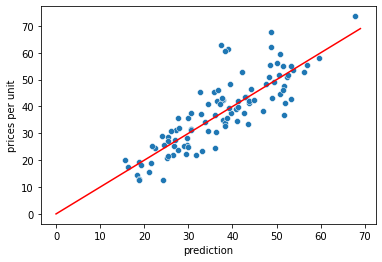

In [35]:
results.append(Constructor(KNeighborsRegressor(weights="distance", n_neighbors=14, leaf_size=70),xtrain, ytrain, xtest, ytest))

# LR

In [19]:
Tuner({"fit_intercept":["True","False"]}
, LinearRegression(), x, y)

random_search.best_score_ = 0.5993791577516816
random_search.best_params_= {'fit_intercept': 'True'}


/home/mahyar/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LinearRegression()
mean absolute error: 6.719850533110686


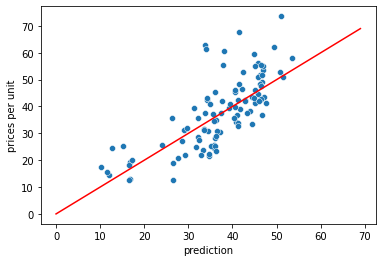

In [36]:
results.append(Constructor(LinearRegression(),xtrain, ytrain, xtest, ytest))

# DTC

In [21]:
Tuner({"splitter":['best',"random"], "max_depth":[x for x in range(5,20)], 
        "min_samples_split":[x/10 for x in range(1,11)], 
        "min_samples_leaf":[x/10 for x in range(1,6)]}
, DecisionTreeRegressor(), x, y)

random_search.best_score_ = 0.6593587498839063
random_search.best_params_= {'splitter': 'best', 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_depth': 10}


DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.1, min_samples_split=0.2)
mean absolute error: 6.416357798701025


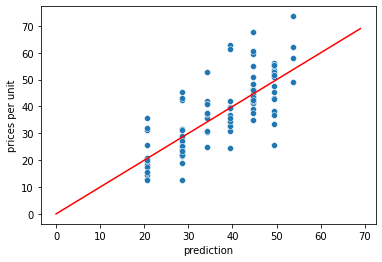

In [37]:
results.append(Constructor(DecisionTreeRegressor(min_samples_split=.2, min_samples_leaf=.1,max_depth=10)
,xtrain, ytrain, xtest, ytest))

# RFC

In [23]:
Tuner({"n_estimators":[x for x in range(100,600,100)], "min_samples_split":[.2,.5,.7], 
    "min_samples_leaf":[x/10 for x in range(1,6)]}
, RandomForestRegressor(), x, y)

random_search.best_score_ = 0.6564267494400999
random_search.best_params_= {'n_estimators': 200, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1}


RandomForestRegressor(min_samples_leaf=0.1, min_samples_split=0.2,
                      n_estimators=200)
mean absolute error: 5.9356104885714105


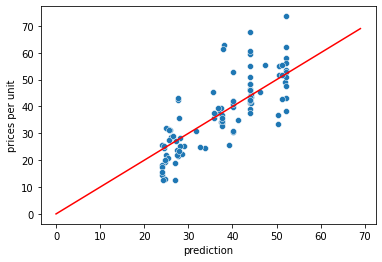

In [38]:
results.append(Constructor(RandomForestRegressor(n_estimators=200, min_samples_leaf=.1, 
min_samples_split=.2)
,xtrain, ytrain, xtest, ytest))

# SVR

In [25]:
Tuner({"tol":[0.001,.1,.01,.0001], "C":[1,10,100,1000], "epsilon":[0.1,1,10,.01]}
, SVR(), x, y)

random_search.best_score_ = 0.6123410483087796
random_search.best_params_= {'tol': 0.01, 'epsilon': 0.1, 'C': 1000}


SVR(C=1000, tol=0.01)
mean absolute error: 6.16843302804678


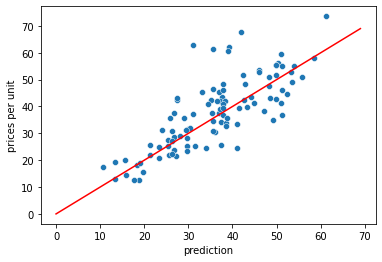

In [39]:
results.append(Constructor(SVR(tol=.01,C=1000,epsilon=.1),xtrain, ytrain, xtest, ytest))

# Results

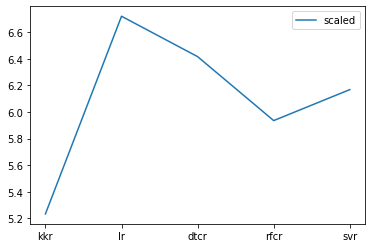

In [40]:
sns.lineplot(x=["kkr","lr","dtcr","rfcr","svr"],y=results)
plt.legend(["scaled","pca","pca-scaled"])